In [179]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


In [180]:
base_skin_dir = os.path.join('..', 'input')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

In [181]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'))# Creating New Columns for better readability


In [182]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/', '*', '*.jpg'))}
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [183]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

In [184]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [185]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [186]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
x_train = x_train.reshape(x_train.shape[0], *(64, 64, 3))
x_test = x_test.reshape(x_test.shape[0], *(64, 64, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(64, 64, 3))

In [187]:
input_shape = (64, 64, 3)
num_classes = 7

filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [188]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation="relu",padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation="relu",padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation="relu",padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

optimizer = Adam()
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [189]:
y_train.shape

(7210, 7)

In [190]:
epochs = 25
batch_size = 64
history_32= model.fit(x_train,y_train, batch_size=batch_size,validation_data=(x_test,y_test),
                              epochs = epochs,verbose=1)

Epoch 1/25
113/113 [==============================] - 2s 14ms/step - loss: 1.0922 - accuracy: 0.6552 - val_loss: 1.0148 - val_accuracy: 0.6550
Epoch 2/25
113/113 [==============================] - 1s 11ms/step - loss: 0.8775 - accuracy: 0.6914 - val_loss: 0.8429 - val_accuracy: 0.6895
Epoch 3/25
113/113 [==============================] - 1s 11ms/step - loss: 0.8261 - accuracy: 0.6990 - val_loss: 0.8372 - val_accuracy: 0.7219
Epoch 4/25
113/113 [==============================] - 1s 11ms/step - loss: 0.7818 - accuracy: 0.7157 - val_loss: 0.8175 - val_accuracy: 0.7259
Epoch 5/25
113/113 [==============================] - 1s 10ms/step - loss: 0.7515 - accuracy: 0.7302 - val_loss: 0.7525 - val_accuracy: 0.7284
Epoch 6/25
113/113 [==============================] - 1s 10ms/step - loss: 0.7196 - accuracy: 0.7369 - val_loss: 0.8332 - val_accuracy: 0.7099
Epoch 7/25
113/113 [==============================] - 1s 10ms/step - loss: 0.7038 - accuracy: 0.7430 - val_loss: 0.7399 - val_accuracy: 0.7344

In [191]:
predictions = model.predict(x_test)
y_test_t=np.argmax(y_test)

In [192]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

63/63 [==============================] - 0s 3ms/step - loss: 0.7620 - accuracy: 0.7469
Test accuracy: 0.7468796968460083


In [193]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(7), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [194]:
y_test_t=np.argmax(y_test, axis=1)

In [195]:
class_names = ['nv', 'mel','bkl', 'bcc', 
               'akiec', 'vasc', 'df']


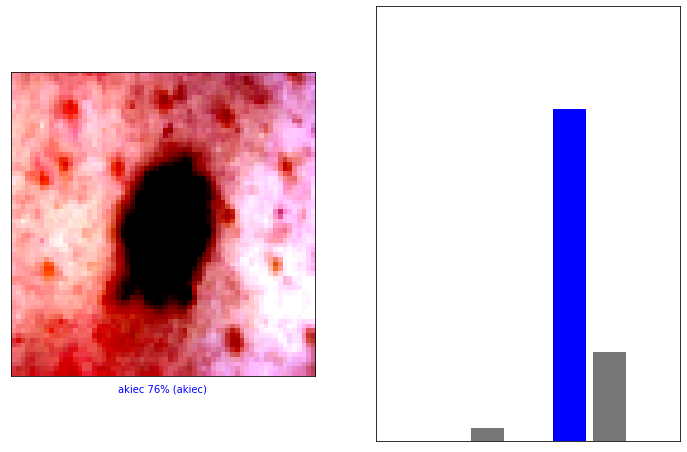

In [196]:
i = 659
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test_t, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_test_t)
plt.show()

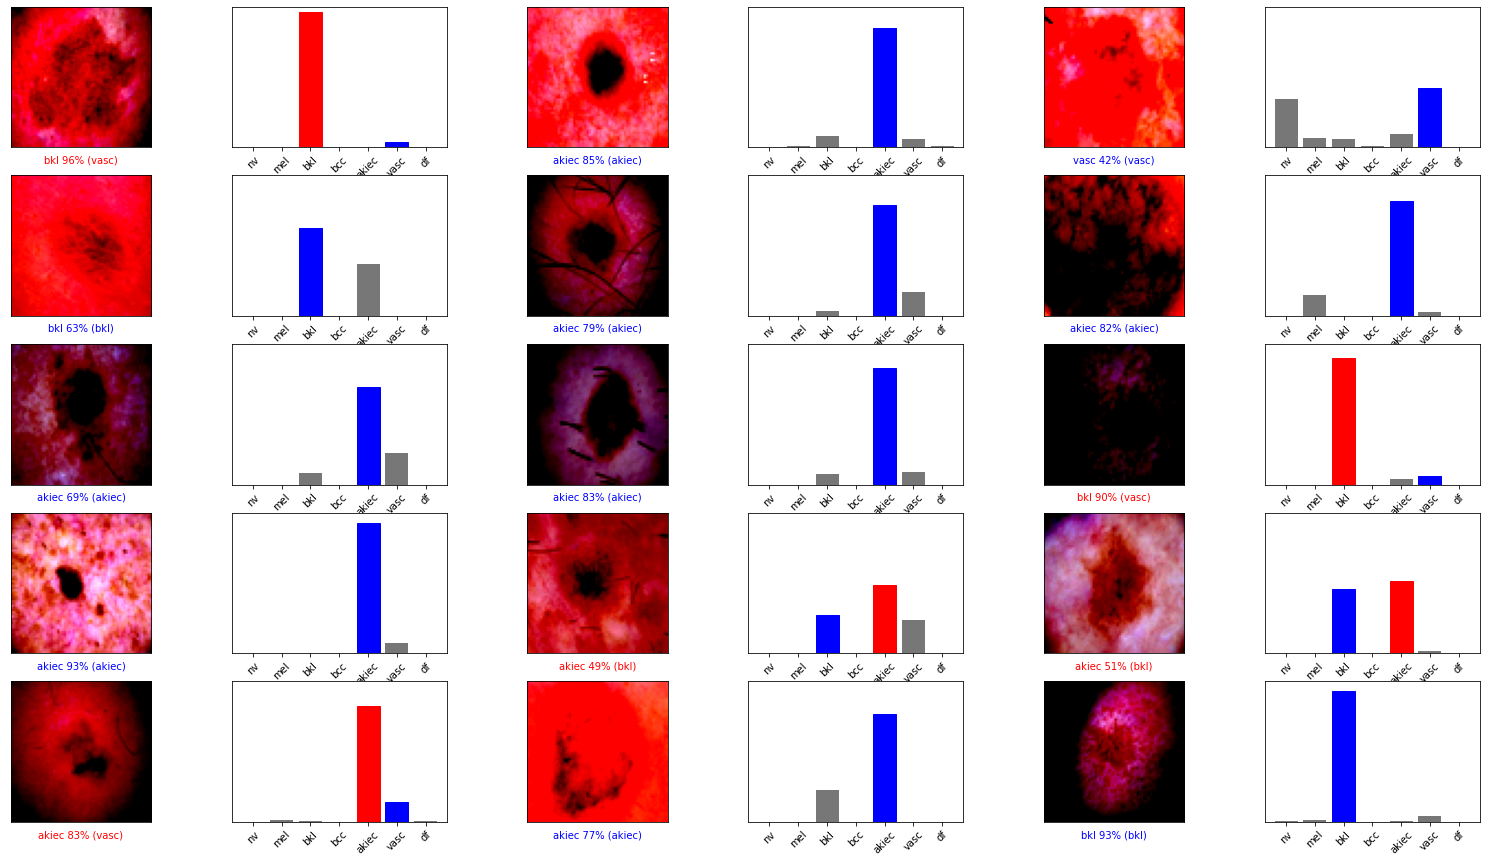

In [197]:

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(3*3*num_cols, 3*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, y_test_t, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, y_test_t)
  _ = plt.xticks(range(7), class_names, rotation=45)
    
    

plt.show()

In [198]:
from tensorflow.keras import Model
import tensorflow as tf
from keras import models

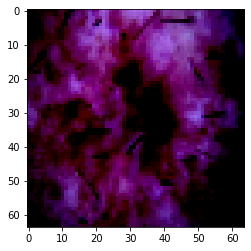

In [199]:

test_im = x_train[55]
plt.imshow(test_im.reshape(64,64,3), cmap='Set1', interpolation='none')
plt.show()

In [200]:

layer_outputs = [layer.output for layer in model.layers[:12]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # 
activations = activation_model.predict(test_im.reshape(1,64,64,3))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


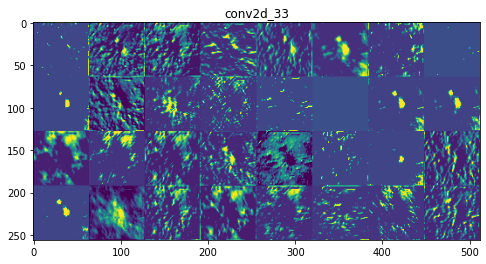

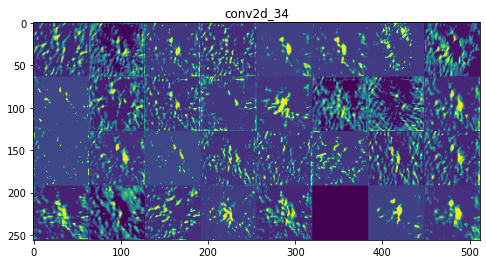

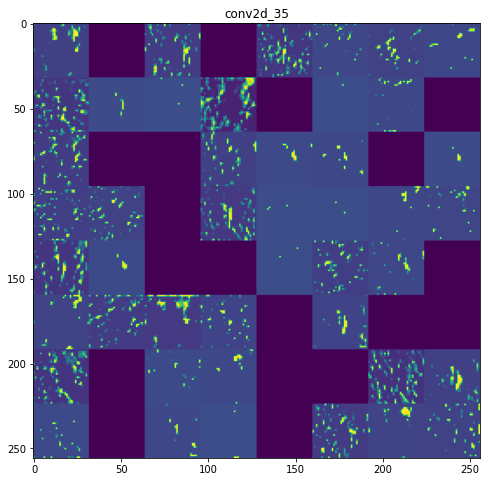

In [201]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 8
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 64
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1]*1,
                            scale * display_grid.shape[0]*1))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto')